Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2247
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Writing the train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height,img_width),
    )

Found 2247 files belonging to 9 classes.
Using 1798 files for training.


In [7]:
## Writing the validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height,img_width),
    )

Found 2247 files belonging to 9 classes.
Using 449 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Creating a code to visualize one instance of all the nine classes present in the dataset

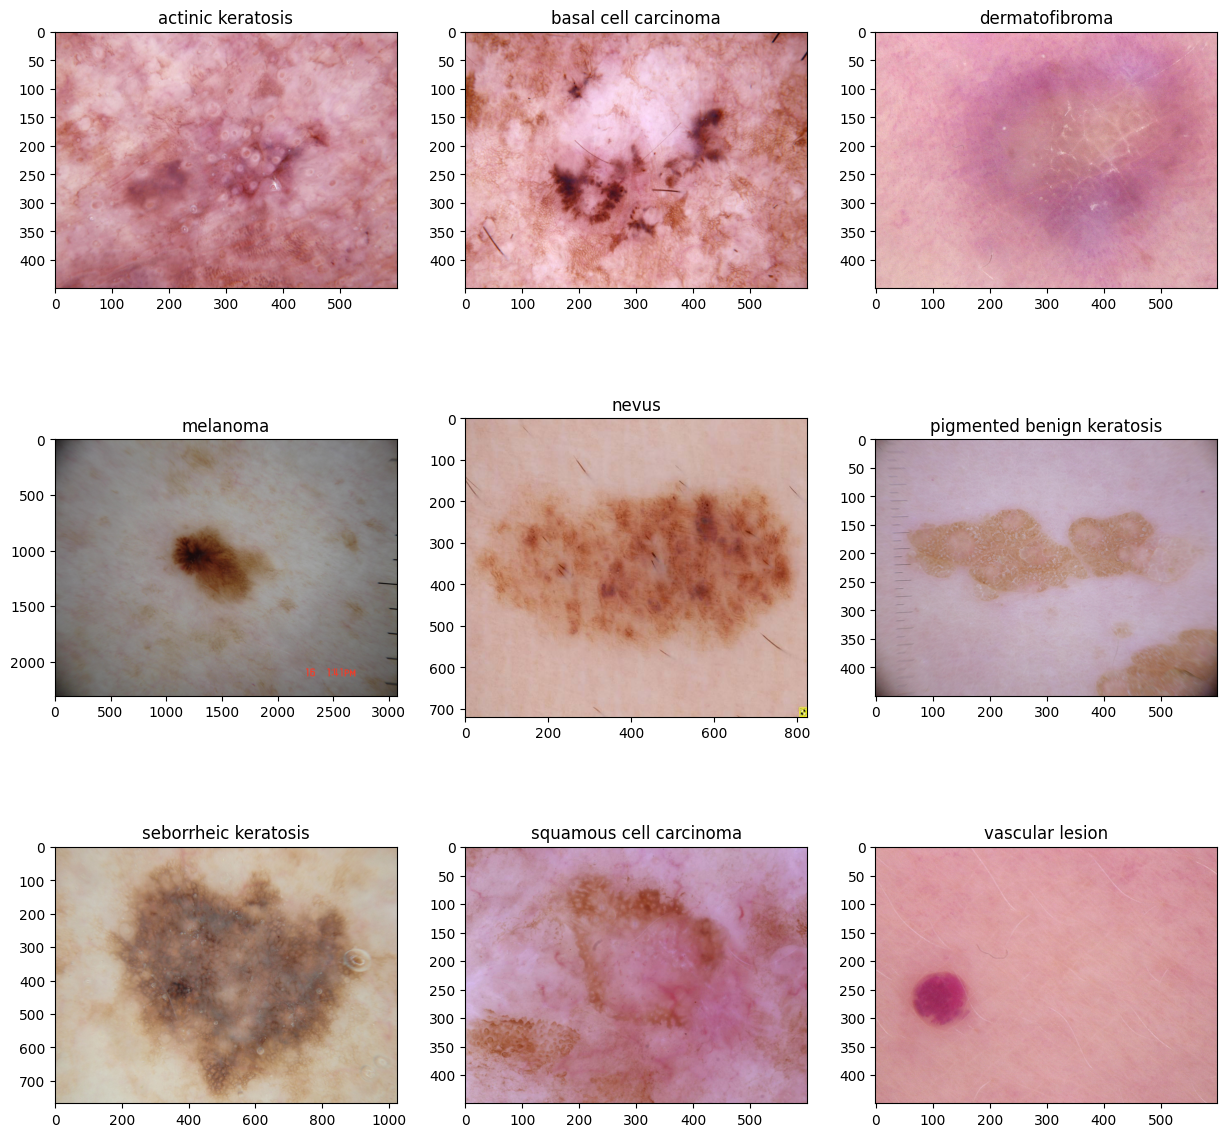

In [9]:
import matplotlib.pyplot as plt

### visualize one instance of all the nine classes present in the dataset
plt.figure(figsize=(15,15))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout

model = Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(len(class_names),activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Choosing an appropiate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        5

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 259s 881ms/step - loss: 2.0587 - accuracy: 0.1991 - val_loss: 2.0353 - val_accuracy: 0.2049
Epoch 2/20
57/57 [==============================] - 1s 17ms/step - loss: 2.0066 - accuracy: 0.2308 - val_loss: 1.9318 - val_accuracy: 0.3073
Epoch 3/20
57/57 [==============================] - 1s 16ms/step - loss: 1.8010 - accuracy: 0.3587 - val_loss: 1.9712 - val_accuracy: 0.2628
Epoch 4/20
57/57 [==============================] - 1s 16ms/step - loss: 1.8120 - accuracy: 0.3181 - val_loss: 1.8004 - val_accuracy: 0.3341
Epoch 5/20
57/57 [==============================] - 1s 16ms/step - loss: 1.6346 - accuracy: 0.4143 - val_loss: 1.7015 - val_accuracy: 0.3742
Epoch 6/20
57/57 [==============================] - 1s 16ms/step - loss: 1.5479 - accuracy: 0.4561 - val_loss: 1.6461 - val_accuracy: 0.3808
Epoch 7/20
57/57 [==============================] - 1s 17ms/step - loss: 1.4605 - accuracy: 0.4828 - val_loss: 1.6186 - val_accuracy: 0.4432
Epoch 8/20

### Visualizing training results

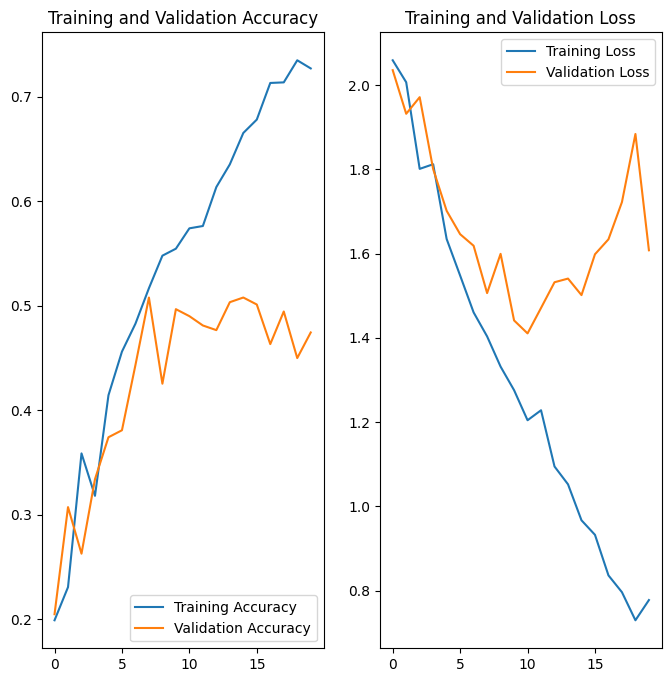

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, see if there is an evidence of model overfit or underfit

### Conclusions

Based on the results above, we can conclude that there is significant overfitting between the training and testing dataset. While training accuracy is 73%, validation accuracy is 47%.

Also we can see from the plot that, as the epoch proceeds the gap between the training and validation accuracy increases. Simultaneously, we could see that the loss increases for validation data whereas it decreases for train data, with each progressing epoch.

These are clear signs of overfitting

In [16]:
# After having analysed the model fit history for presence of underfit or overfit, choosing an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential([
                             layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.RandomRotation(0.2, fill_mode='reflect'),
                             layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

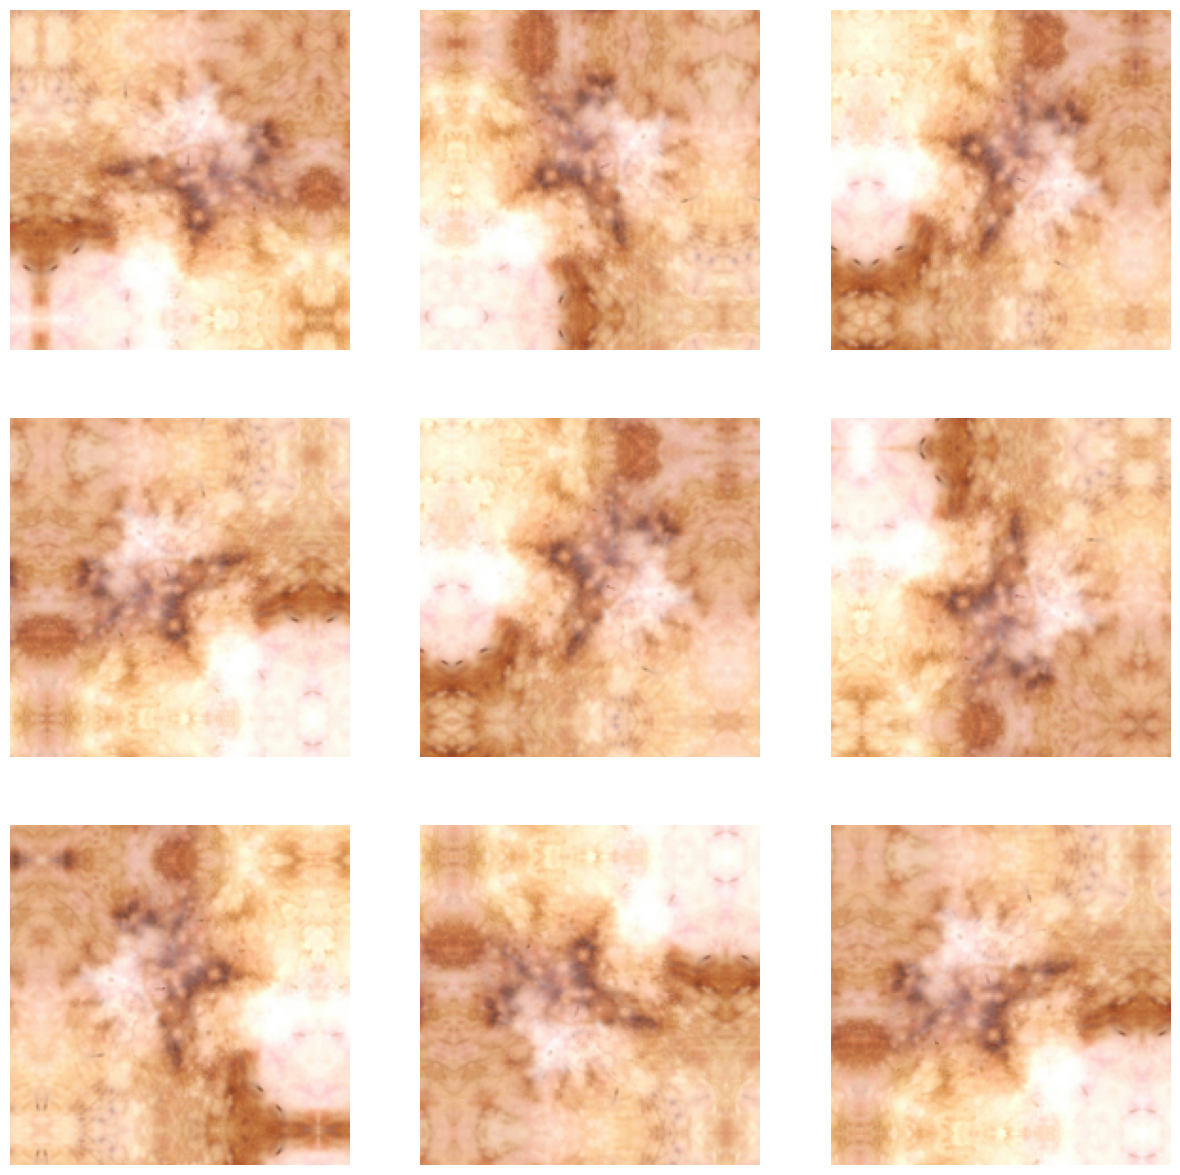

In [17]:
# Visualizing how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(15, 15))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[6].numpy().astype("uint8"))
    plt.axis("off")

### Creating, compiling and training the model


In [18]:
## Using Dropout layer as there is an evidence of overfitting in the previous findings
from keras.layers import Dropout

model2 = Sequential([data_augmentation, layers.Rescaling(1./255, input_shape=(img_height, img_width,3))])
model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(len(class_names), activation = "softmax"))

### Compiling the model

In [19]:
### Choosing an appropiate optimiser and loss function
model2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        51264     
                                                      

### Training the model

In [21]:
## Code goes here, note: train your model for 20 epochs
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 6s 46ms/step - loss: 2.0499 - accuracy: 0.1947 - val_loss: 2.0129 - val_accuracy: 0.1759
Epoch 2/20
57/57 [==============================] - 2s 39ms/step - loss: 1.9527 - accuracy: 0.2514 - val_loss: 1.9186 - val_accuracy: 0.2873
Epoch 3/20
57/57 [==============================] - 2s 38ms/step - loss: 2.0005 - accuracy: 0.2380 - val_loss: 2.0492 - val_accuracy: 0.1871
Epoch 4/20
57/57 [==============================] - 2s 38ms/step - loss: 2.0794 - accuracy: 0.2002 - val_loss: 2.0314 - val_accuracy: 0.2049
Epoch 5/20
57/57 [==============================] - 2s 38ms/step - loss: 2.0264 - accuracy: 0.2058 - val_loss: 2.0282 - val_accuracy: 0.2049
Epoch 6/20
57/57 [==============================] - 2s 38ms/step - loss: 2.0201 - accuracy: 0.2108 - val_loss: 2.0409 - val_accuracy: 0.1871
Epoch 7/20
57/57 [==============================] - 2s 38ms/step - loss: 2.0139 - accuracy: 0.2158 - val_loss: 2.0227 - val_accuracy: 0.2027
Epoch 8/20
57

### Visualizing the results

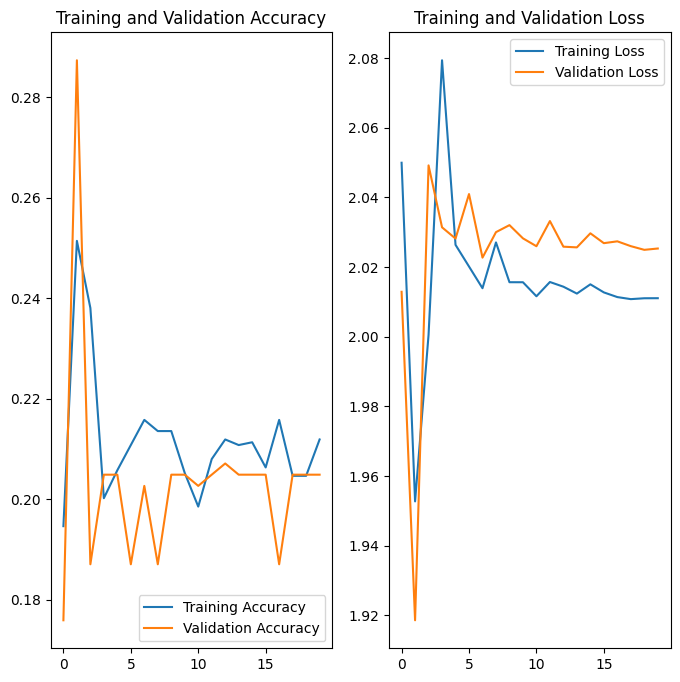

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We could still see there is no overfitting of the model compared to Model 01. The Model 02 has a validation accuracy of 20% but a severely decreased training accuracy of 21%. 

#### We can also see that the difference between the loss and accuracy of the training and validation data set has improved a lot, although the training accuracy is much lower.

#### **Finding the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

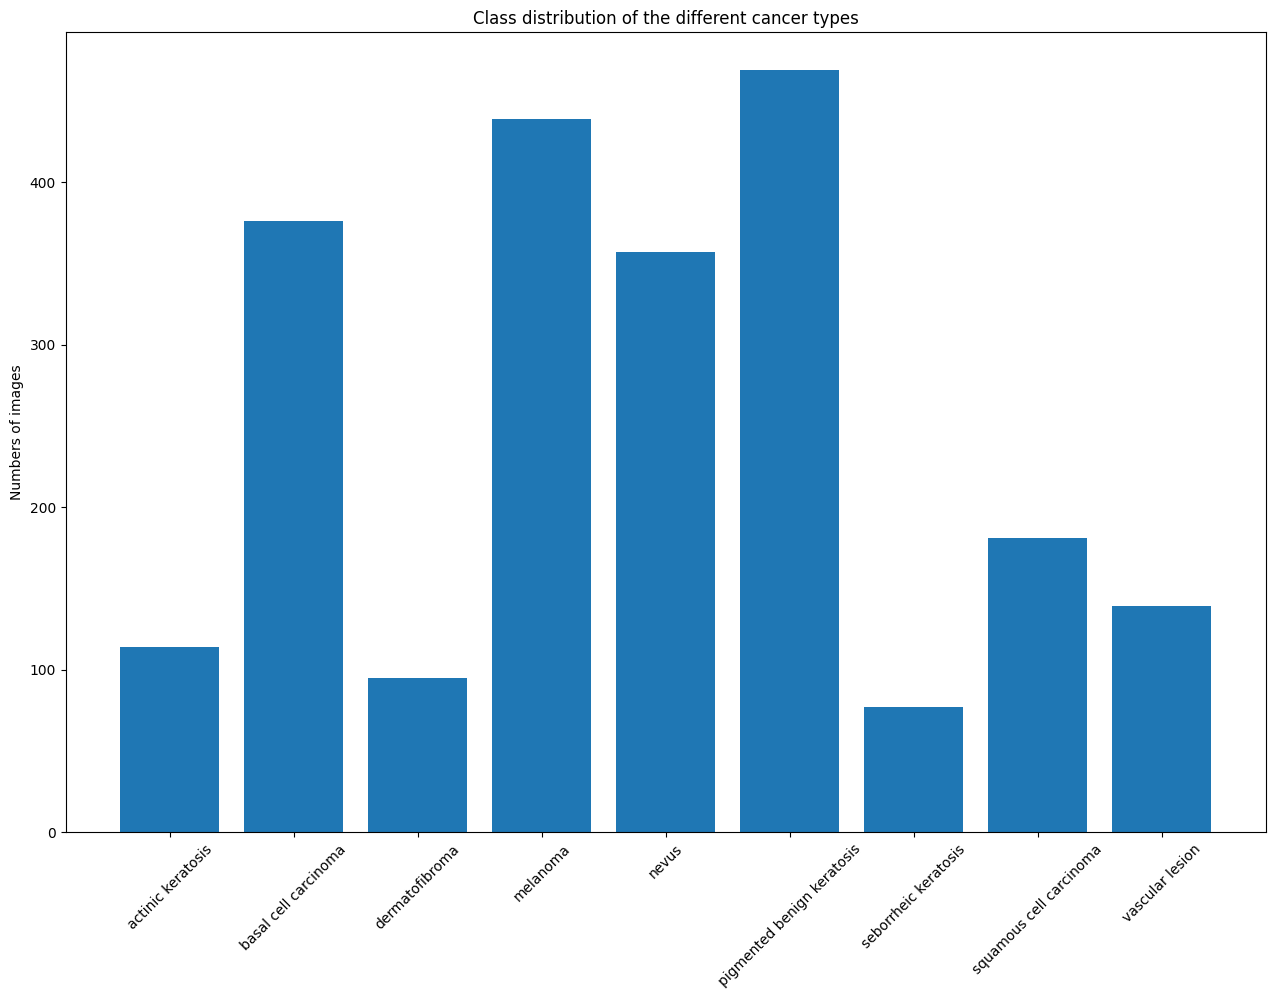

In [23]:
## Your code goes here
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types')
plt.xticks(rotation=45)
plt.show()

In [24]:
print("Number of samples for each class: ")
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

Number of samples for each class: 
actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  439
nevus  -  357
pigmented benign keratosis  -  469
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


- We could see that the class seborrheic keratosis has the least number of samples 
- We could also see that basal cell carcinoma, melanoma, nevus and pigmented benign keratosis dominate the data in terms proportionate number of samples 
- The largest number of samples belong to pigmented benign keratosis


#### **Rectifying the class imbalance**
#### **Context:** Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="/content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE85812FBB0>: 100%|██████████| 500/500 [00:13<00:00, 38.33 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE842237340>: 100%|██████████| 500/500 [00:14<00:00, 35.62 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE858103E20>: 100%|██████████| 500/500 [00:11<00:00, 42.39 Samples/s]


Initialised with 439 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE858F84FD0>: 100%|██████████| 500/500 [00:53<00:00,  9.28 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE859B3F010>: 100%|██████████| 500/500 [01:01<00:00,  8.11 Samples/s]


Initialised with 469 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE8580F6EF0>: 100%|██████████| 500/500 [00:11<00:00, 42.73 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE858F58EB0>: 100%|██████████| 500/500 [00:23<00:00, 21.10 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE859B3D0F0>: 100%|██████████| 500/500 [00:11<00:00, 45.45 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE842262380>: 100%|██████████| 500/500 [00:11<00:00, 45.11 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [28]:
#Installing glob in Python3
!pip install glob2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob2 import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024435.jpg_aff204b9-5932-4473-a766-162871f1eca4.jpg',
 '/content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025345.jpg_574b67ff-7f40-47a9-a13b-12bd6988d54c.jpg',
 '/content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024708.jpg_6780a4e4-47da-4c9d-af3d-95f28164842d.jpg',
 '/content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026737.jpg_845152e1-0a29-421e-8e15-336b155876f3.jpg',
 '/content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024676.jpg_723f4ed0-aa23-43d8-8a8c-8d3362df1fde.jpg',
 '/content/gdrive/MyDrive/ML_C47_CN

In [30]:
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [32]:
## Generating dataset to get counts before rebalancing
path_list_old=[]
lesion_list_old=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list_old.append(str(j))
        lesion_list_old.append(i)
dataframe_dict_original = dict(zip(path_list_old, lesion_list_old))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

Path              Label
0     /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...  actinic keratosis
1     /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...  actinic keratosis
2     /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...  actinic keratosis
3     /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...  actinic keratosis
4     /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...  actinic keratosis
...                                                 ...                ...
2242  /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...    vascular lesion
2243  /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...    vascular lesion
2244  /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...    vascular lesion
2245  /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...    vascular lesion
2246  /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...    vascular lesion

[2247 rows x 2 columns]

In [31]:
## Generating dataframe for final no of counts after balancing
data_dir_train1 = pathlib.Path("/content/drive/MyDrive/ML_C47_CNN_Skin_Cancer_Dataset/Train/")
for i in class_names:
    for j in data_dir_train1.glob(i+'/output/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
new_df

Path  \
0     /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...   
1     /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...   
2     /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...   
3     /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...   
4     /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...   
...                                                 ...   
4495  /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...   
4496  /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...   
4497  /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...   
4498  /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...   
4499  /content/gdrive/MyDrive/ML_C47_CNN_Skin_Cancer...   

                           Label  
0     pigmented benign keratosis  
1     pigmented benign keratosis  
2     pigmented benign keratosis  
3     pigmented benign keratosis  
4     pigmented benign keratosis  
...                          ...  
4495              dermatofibroma  
4496              dermatofibroma  
4497              dermatofibroma  
4498              dermatofibroma  
4499              dermatofibroma  

[4500 rows x 2 columns]

In [33]:
#As we have added 500 new samples so the final list looks like
df = pd.concat([original_df, new_df], axis=0)
df['Label'].value_counts()

pigmented benign keratosis    969
melanoma                      939
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

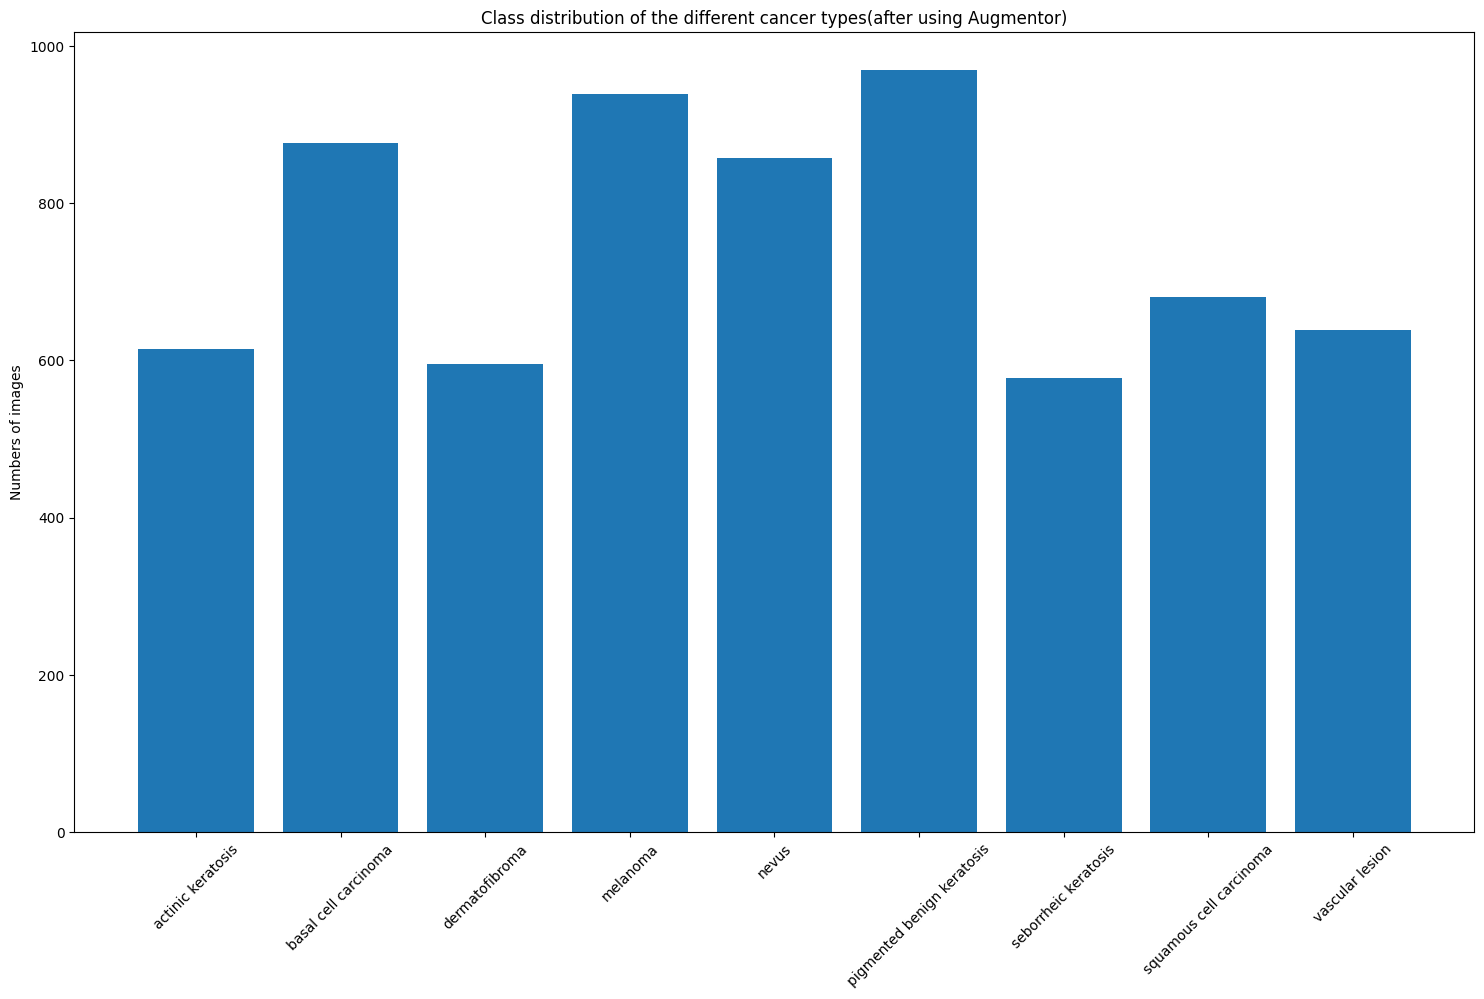

In [34]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))) + len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types(after using Augmentor)')
plt.xticks(rotation=45)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [37]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 6747 files belonging to 9 classes.
Using 5398 files for training.


#### Creating a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6747 files belonging to 9 classes.
Using 1349 files for validation.


#### Creating the model (including normalization)

In [49]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model3 = Sequential()

model3.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convolution layer
model3.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convolution Layer
model3.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convolution Layer
model3.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))
model3.add(layers.BatchNormalization())

#Dropout layer with 25% Fraction of the input units to drop.
model3.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model3.add(layers.Dense(len(class_names),activation='softmax'))

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 41, 41, 128)      

#### Compiling the model 

In [50]:
### Choosing an appropiate optimiser and loss function
model3.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [51]:
# View the summary of all layers
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 41, 41, 128)      

#### Training the model

In [52]:
## Using 30 epochs.
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 24s 122ms/step - loss: 1.7732 - accuracy: 0.3559 - val_loss: 1.7717 - val_accuracy: 0.3944
Epoch 2/30
169/169 [==============================] - 21s 122ms/step - loss: 1.4402 - accuracy: 0.4635 - val_loss: 2.9151 - val_accuracy: 0.2980
Epoch 3/30
169/169 [==============================] - 22s 122ms/step - loss: 1.3092 - accuracy: 0.5178 - val_loss: 1.2736 - val_accuracy: 0.5226
Epoch 4/30
169/169 [==============================] - 21s 122ms/step - loss: 1.1900 - accuracy: 0.5695 - val_loss: 1.2138 - val_accuracy: 0.5196
Epoch 5/30
169/169 [==============================] - 21s 119ms/step - loss: 1.0868 - accuracy: 0.5995 - val_loss: 1.4351 - val_accuracy: 0.4477
Epoch 6/30
169/169 [==============================] - 22s 124ms/step - loss: 1.0584 - accuracy: 0.6208 - val_loss: 1.6483 - val_accuracy: 0.4685
Epoch 7/30
169/169 [==============================] - 21s 122ms/step - loss: 0.9848 - accuracy: 0.6460 - val_loss: 0.9663 - val_ac

#### Visualizing the model results

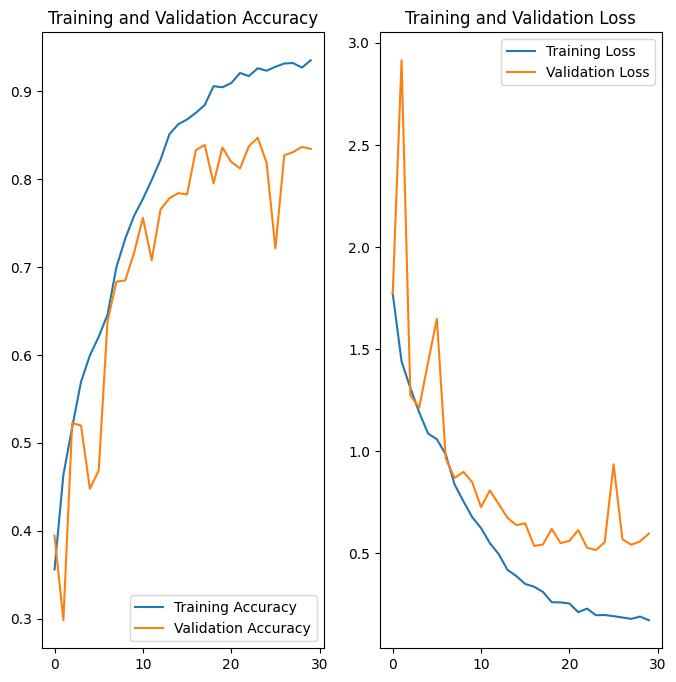

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing the results here. Did we get rid of underfitting/overfitting? Did class rebalance help?



Class rebalance has helped in improving the training accuracy to 93%, and also the test validation to 83%. Also the loss has reduced, albeit in an oscillating manner. Therefore we have reduced the overfitting issue to some extent faced in Model 01 and also the accuracy issue faced in Model 02.